In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bike-sharing-demand/test.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/sampleSubmission.csv


# Importing important libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
import plotly.express as px

# Loading the training dataset

In [3]:
#Reading the file
file = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")

In [4]:
file.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


# Checking for null values

In [5]:
file.isnull().sum(axis=0)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

No data cleaning is required since no Null values are found!

In [6]:
file.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

# Data visualization:

## Heatmap of all the continuous values in the file.

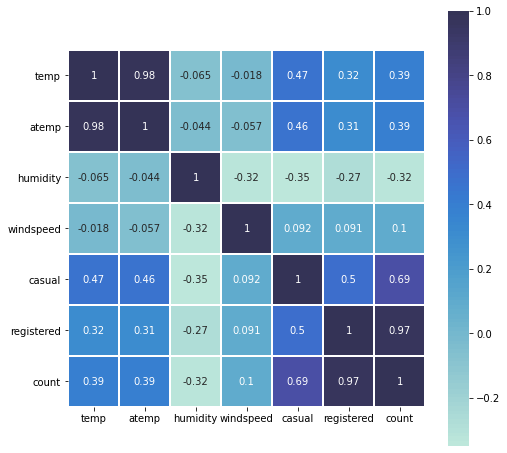

In [7]:
corr = file[['temp','atemp','humidity', 'windspeed','casual', 'registered','count']].corr()
f,axes = plt.subplots(1,1,figsize = (8,8))
sb.heatmap(corr,square=True,annot = True,linewidth = .5,center = 1.4,ax = axes)

### The conclusions drawn are:
1. We can see that temp and atemp have a very strong positive correlation therefore we can use only temp as a variable without any loss of information. 

2. We can infer from the correlaton matrix that windspeed has almost no correlation with the casual,registered or count which we wish to predict so we can remove that

## Data visualizaton for non continuous variables in data

First we have to separate the individual date and time for each data point into hour,day,month and year.

In [8]:
file = file
file['Date'] = pd.DatetimeIndex(file['datetime']).date
file['Hour'] = pd.DatetimeIndex(file['datetime']).hour
file['Day'] = pd.DatetimeIndex(file['datetime']).day
file['Month'] = pd.DatetimeIndex(file['datetime']).month
file['Year'] = pd.DatetimeIndex(file['datetime']).year

In [9]:
a = []
for i in file.index:
    a.append('Total Count : '+str(file['count'][i]))
file['count_vis'] = a

In [10]:
fig = px.line(x = 'Date', y = "count", data_frame = file,color = 'Hour',range_y = (0,1150),
              title = 'Interactive LinePlot of the whole dataset(Hover for more details)',
              hover_data = ['Hour','Date','casual','registered'],
              hover_name = 'count_vis', text = None,
              height = 670,width = 980)
fig.show()

**The sudden periodic changes between the differrent regions is due to the missing data.These are the regions in which the regions we have to predict the result.**

## 1. Season

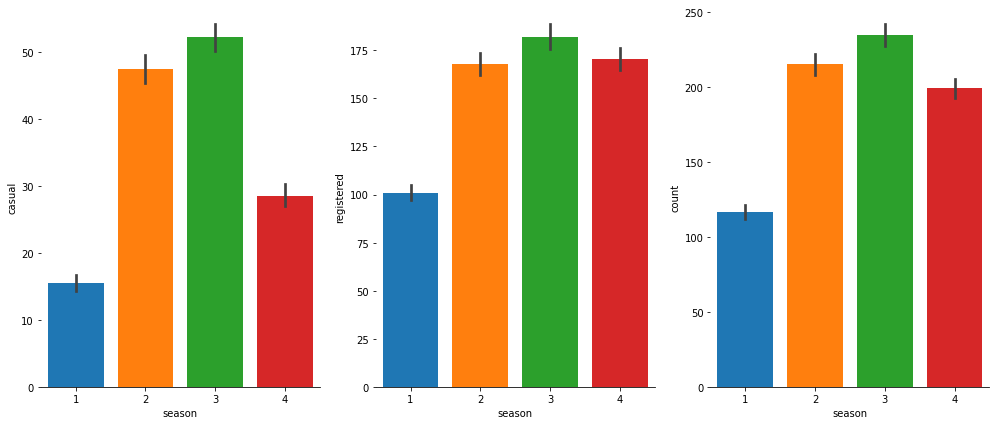

In [11]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'season'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0])
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

## 2. Holiday

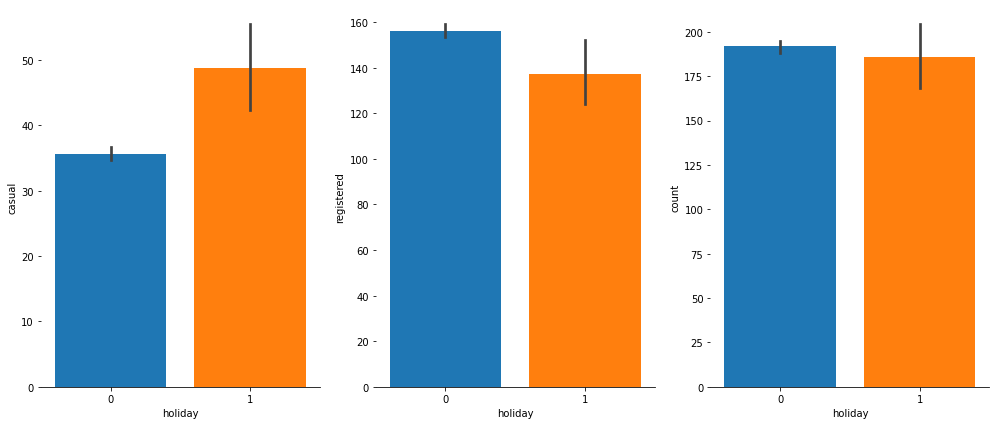

In [12]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'holiday'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

## 3. Working day

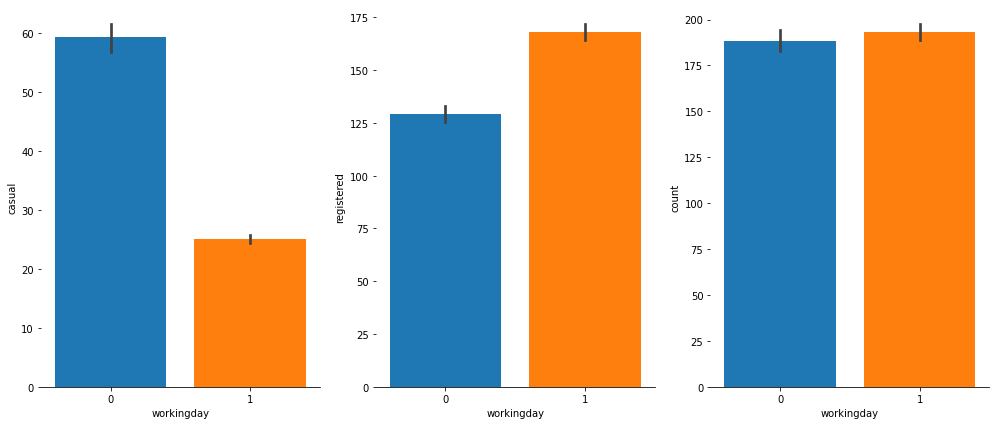

In [13]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'workingday'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

Combining the graphs of casual and registered into one of may make it seem like that holiday and workingday have no dependence on count but we can clearly see that holiday increases the casual amount by upto 40% and a reverse kind of trend is observed in working day so it is reasonable to take two different models one for casual and another for registered.

Therefore what I will attempt to do is make two separate models for the casual and the registerd training them separately and then adding the result to get the count.

## 4. Weather

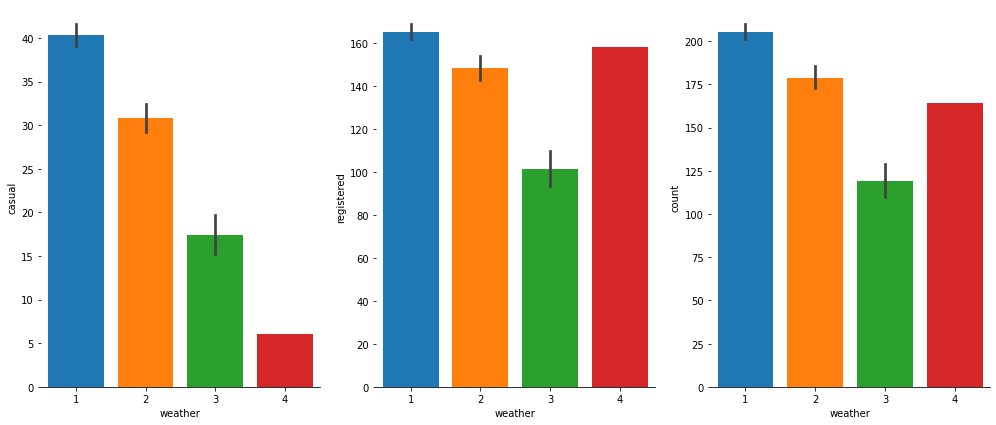

In [14]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'weather'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

## 5. Date and Time

### 5.a. Hour

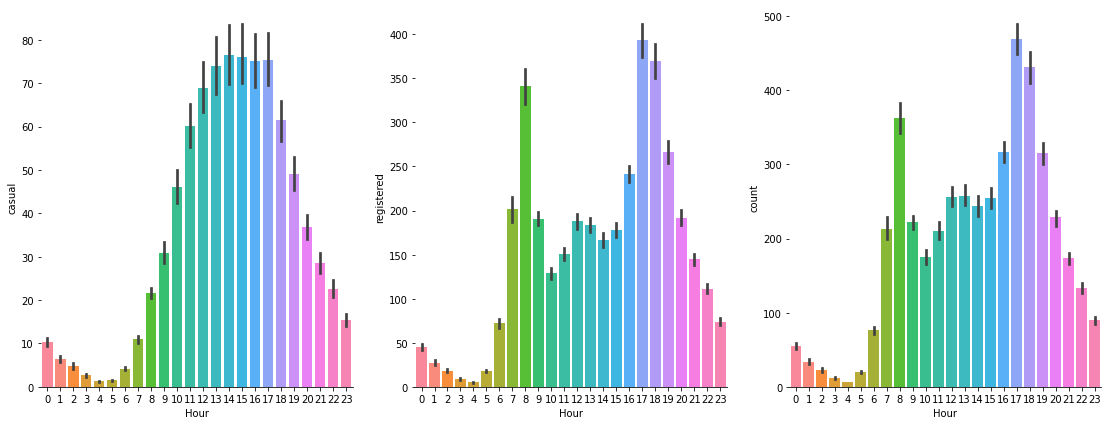

In [15]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Hour'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

We can see that in the final graph there are two prominent peaks.
1. At 8 a.m
2. At 5 p.m
Where as the trend of casual is mostly the same throughout the day. 

From this we can conclude that the registered are mostly people going on their jobs which explains the peaks at the start and end of office hours. Clearly these people would have a more definite and predictible schedule and are therefore more likely to be registered.

### 5.b. Day

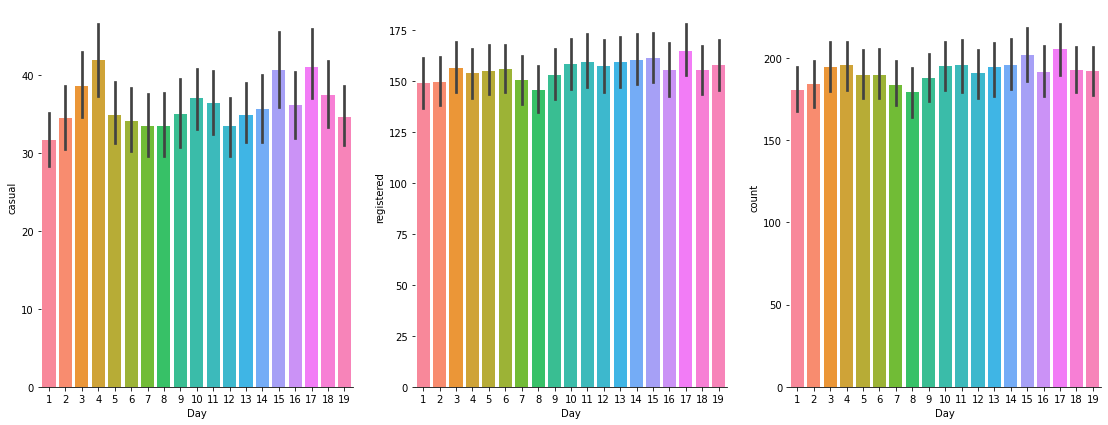

In [16]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Day'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

**From the above graphs we can conclude that the feature day has hardly any influence over the features registered and count.**

### 5.c. Month

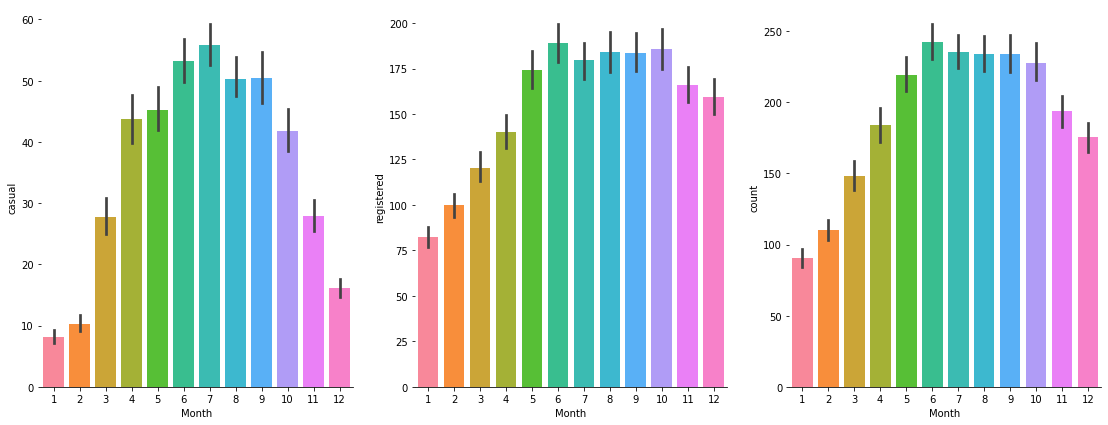

In [17]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Month'
#order = ['January','February','March','April','May','June','July','August','September','October','November','December']
plot = sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0])
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

### 5.d. Year 

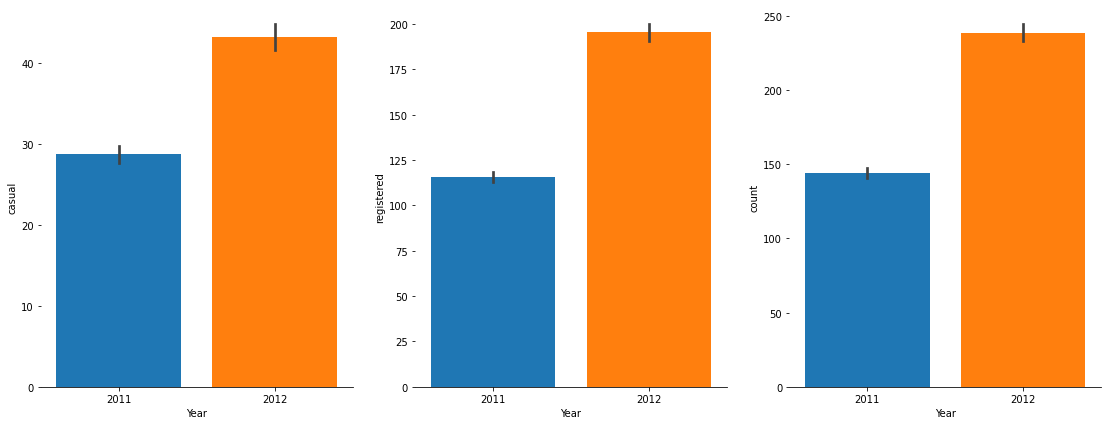

In [18]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Year'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

In [19]:
file.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Hour,Day,Month,Year
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613,9.992559,6.521495,2011.501929
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838,5.476608,3.444373,0.500019
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2011.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000,5.000000,4.000000,2011.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000,10.000000,7.000000,2012.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000,15.000000,10.000000,2012.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,19.000000,12.000000,2012.000000


In [20]:
file.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'Date', 'Hour', 'Day', 'Month', 'Year', 'count_vis'],
      dtype='object')

# Adding relevant columns for each of the categorical data columns and removing unnecesary ones

## 1. Season

In [21]:
for i in file.groupby('season').count().index:
    s = 's'+str(i)
    a=[]
    for j in file.season:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    file[s]=a
file.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Date,Hour,Day,Month,Year,count_vis,s1,s2,s3,s4
4781,2011-11-12 07:00:00,4,0,0,1,9.02,11.365,75,12.9980,3,...,2011-11-12,7,12,11,2011,Total Count : 27,0,0,0,1
4292,2011-10-10 21:00:00,4,1,0,1,22.96,26.515,88,6.0032,27,...,2011-10-10,21,10,10,2011,Total Count : 175,0,0,0,1
8180,2012-07-02 05:00:00,3,0,1,2,29.52,33.335,51,0.0000,3,...,2012-07-02,5,2,7,2012,Total Count : 40,0,0,1,0
1875,2011-05-05 01:00:00,2,0,1,1,13.94,16.665,71,12.9980,4,...,2011-05-05,1,5,5,2011,Total Count : 10,0,1,0,0
6323,2012-02-19 17:00:00,1,0,0,2,12.30,14.395,49,16.9979,22,...,2012-02-19,17,19,2,2012,Total Count : 157,1,0,0,0


## 2. Weather 

In [22]:
for i in file.groupby('weather').count().index:
    s = 'w'+str(i)
    a=[]
    for j in file.weather:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    file[s]=a
file.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Year,count_vis,s1,s2,s3,s4,w1,w2,w3,w4
4647,2011-11-06 17:00:00,4,0,0,1,18.04,21.970,62,11.0014,71,...,2011,Total Count : 256,0,0,0,1,1,0,0,0
1688,2011-04-16 06:00:00,2,0,0,3,16.40,20.455,82,22.0028,1,...,2011,Total Count : 10,0,1,0,0,0,0,1,0
6976,2012-04-09 00:00:00,2,0,1,1,19.68,23.485,39,19.0012,8,...,2012,Total Count : 37,0,1,0,0,1,0,0,0
6125,2012-02-11 11:00:00,1,0,0,2,9.84,12.880,81,7.0015,26,...,2012,Total Count : 183,1,0,0,0,0,1,0,0
2597,2011-06-16 03:00:00,2,0,1,2,22.96,26.515,73,6.0032,0,...,2011,Total Count : 4,0,1,0,0,0,1,0,0


## 3. Hour

In [23]:
for i in file.groupby('Hour').count().index:
    s = 'Hour'+str(i)
    a=[]
    for j in file.Hour:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    file[s]=a
file.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Hour14,Hour15,Hour16,Hour17,Hour18,Hour19,Hour20,Hour21,Hour22,Hour23
3722,2011-09-06 00:00:00,3,0,1,3,22.14,25.760,94,23.9994,1,...,0,0,0,0,0,0,0,0,0,0
1087,2011-03-09 20:00:00,1,0,1,2,13.12,15.910,87,12.9980,4,...,0,0,0,0,0,0,1,0,0,0
7445,2012-05-09 14:00:00,2,0,1,2,26.24,31.060,53,16.9979,68,...,1,0,0,0,0,0,0,0,0,0
8939,2012-08-14 20:00:00,3,0,1,1,30.34,35.605,74,15.0013,65,...,0,0,0,0,0,0,1,0,0,0
4174,2011-10-05 23:00:00,4,0,1,1,20.50,24.240,77,7.0015,9,...,0,0,0,0,0,0,0,0,0,1


## 4.Month

In [24]:
for i in file.groupby("Month").count().index:
    s = 'Month' + str(i)
    a = []
    for j in file.Month:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    file[s] = a
file.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Month3,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Month12
8521,2012-07-16 10:00:00,3,0,1,1,32.80,38.635,59,0.0000,69,...,0,0,0,0,1,0,0,0,0,0
2943,2011-07-11 13:00:00,3,0,1,1,35.26,40.910,50,16.9979,22,...,0,0,0,0,1,0,0,0,0,0
2027,2011-05-11 09:00:00,2,0,1,1,21.32,25.000,72,8.9981,21,...,0,0,1,0,0,0,0,0,0,0
3400,2011-08-11 14:00:00,3,0,1,1,32.80,34.850,29,0.0000,39,...,0,0,0,0,0,1,0,0,0,0
8822,2012-08-09 23:00:00,3,0,1,1,27.06,31.060,74,0.0000,19,...,0,0,0,0,0,1,0,0,0,0


In [25]:
file.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'Date', 'Hour', 'Day', 'Month', 'Year', 'count_vis', 's1', 's2', 's3',
       's4', 'w1', 'w2', 'w3', 'w4', 'Hour0', 'Hour1', 'Hour2', 'Hour3',
       'Hour4', 'Hour5', 'Hour6', 'Hour7', 'Hour8', 'Hour9', 'Hour10',
       'Hour11', 'Hour12', 'Hour13', 'Hour14', 'Hour15', 'Hour16', 'Hour17',
       'Hour18', 'Hour19', 'Hour20', 'Hour21', 'Hour22', 'Hour23', 'Month1',
       'Month2', 'Month3', 'Month4', 'Month5', 'Month6', 'Month7', 'Month8',
       'Month9', 'Month10', 'Month11', 'Month12'],
      dtype='object')

## Removing unnecessary columns

In [26]:
feed = file[['Hour0', 'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5',
       'Hour6', 'Hour7', 'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12',
       'Hour13', 'Hour14', 'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19',
       'Hour20', 'Hour21', 'Hour22', 'Hour23','Month1', 'Month2', 'Month3',
       'Month4', 'Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10',
       'Month11', 'Month12','Year','s1','s2','s3','s4','holiday','workingday',
        'w1','w2','w3','w4','temp','humidity','casual','registered']]

In [27]:
feed.describe()

,Hour0,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,holiday,workingday,w1,w2,w3,w4,temp,humidity,casual,registered
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000
mean,0.041797,0.041705,0.041154,0.039776,0.040603,0.041521,0.041797,0.041797,0.041797,0.041797,...,0.028569,0.680875,0.660665,0.260334,0.078909,0.000092,20.23086,61.886460,36.021955,155.552177
std,0.200134,0.199923,0.198655,0.195441,0.197377,0.199502,0.200134,0.200134,0.200134,0.200134,...,0.166599,0.466159,0.473505,0.438837,0.269609,0.009584,7.79159,19.245033,49.960477,151.039033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.82000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.94000,47.000000,4.000000,36.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.50000,62.000000,17.000000,118.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,26.24000,77.000000,49.000000,222.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.00000,100.000000,367.000000,886.000000


In [28]:
feed.columns

Index(['Hour0', 'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5', 'Hour6', 'Hour7',
       'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12', 'Hour13', 'Hour14',
       'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19', 'Hour20', 'Hour21',
       'Hour22', 'Hour23', 'Month1', 'Month2', 'Month3', 'Month4', 'Month5',
       'Month6', 'Month7', 'Month8', 'Month9', 'Month10', 'Month11', 'Month12',
       'Year', 's1', 's2', 's3', 's4', 'holiday', 'workingday', 'w1', 'w2',
       'w3', 'w4', 'temp', 'humidity', 'casual', 'registered'],
      dtype='object')

# Preparing training and testing sets

### 1. Training set

In [29]:
df_train_x = feed.drop('casual',axis = 1).drop('registered',axis=1)
df_train_x.describe()

,Hour0,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,s3,s4,holiday,workingday,w1,w2,w3,w4,temp,humidity
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000
mean,0.041797,0.041705,0.041154,0.039776,0.040603,0.041521,0.041797,0.041797,0.041797,0.041797,...,0.251056,0.251148,0.028569,0.680875,0.660665,0.260334,0.078909,0.000092,20.23086,61.886460
std,0.200134,0.199923,0.198655,0.195441,0.197377,0.199502,0.200134,0.200134,0.200134,0.200134,...,0.433641,0.433694,0.166599,0.466159,0.473505,0.438837,0.269609,0.009584,7.79159,19.245033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.82000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.94000,47.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.50000,62.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,26.24000,77.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.00000,100.000000


### 2. Training set

In [30]:
df_reg_train_y = feed['registered']
df_reg_train_y.describe

<bound method NDFrame.describe of 0         13
1         32
2         27
3         10
4          1
        ... 
10881    329
10882    231
10883    164
10884    117
10885     84
Name: registered, Length: 10886, dtype: int64>

In [31]:
df_cas_train_y = feed['casual']
df_cas_train_y.describe

<bound method NDFrame.describe of 0         3
1         8
2         5
3         3
4         0
         ..
10881     7
10882    10
10883     4
10884    12
10885     4
Name: casual, Length: 10886, dtype: int64>

# Machine learning model

### Splitting data into train and test sets

In [32]:
x1_train, x1_test, y1_train, y1_test = train_test_split(df_train_x, df_cas_train_y, test_size=0.15, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(df_train_x, df_reg_train_y, test_size=0.15, random_state=42)

### Using polynomial on the dataset

In [33]:
poly = PolynomialFeatures(degree=2)
poly_x1_train = poly.fit_transform(x1_train)
poly_x1_test = poly.fit_transform(x1_test)
poly_x2_train = poly.fit_transform(x2_train)
poly_x2_test = poly.fit_transform(x2_test)

### Trying different models to see which one works best for the given data.

In [34]:
predict1=[]
for i in range (0,60,5):
    dt = RandomForestRegressor(n_estimators = 100,max_depth=i+1).fit(x1_train, y1_train)
    pre_dt = dt.predict(x1_test)
    predict1.append(pre_dt)
i=0
for prediction in predict1:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    print(str (i*5+1)+" : "+str(np.sqrt(mean_squared_log_error( y1_test, pre ))))
    i+=1

1 : 1.557824363589933
6 : 1.0892898175350418
11 : 0.8769782791059333
16 : 0.732241621334237
21 : 0.6690135317791535
26 : 0.6475373898103294
31 : 0.6483072570806883
36 : 0.6502599565327741
41 : 0.652656656373391
46 : 0.6523658245279921
51 : 0.6477968301046263
56 : 0.6535044690456568


We can see that the minimum must occur between i=21 and 1=41

In [35]:
predict1=[]
for i in range (20,40,2):
    dt = RandomForestRegressor(n_estimators = 100,max_depth=i+1).fit(x1_train, y1_train)
    pre_dt = dt.predict(x1_test)
    predict1.append(pre_dt)
i=20
for prediction in predict1:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    print(str (i*2+1)+" : "+str(np.sqrt(mean_squared_log_error( y1_test, pre ))))
    i+=1

41 : 0.6699055809282126
43 : 0.6583601121220453
45 : 0.6523262373912796
47 : 0.6517594109931997
49 : 0.6471156084288596
51 : 0.6502203460616744
53 : 0.6479530761674773
55 : 0.652741597874774
57 : 0.650628522639858
59 : 0.6502433799731463


We can conclude that the optimal value for depth = 50 for the random forest after which it starts to overfit for casual.

**P.S: The actual minimum values may vary from instance to instance due to the randomness in the trees generated however the optimal depth will be more or less the same compared to the optimal chosen value**

In [36]:
predict1=[]
for i in range (0,70,5):
    dt = RandomForestRegressor(n_estimators=100,max_depth=i+1).fit(x2_train, y2_train)
    pre_dt = dt.predict(x2_test)
    predict1.append(pre_dt)
i=0
for prediction in predict1:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    print(str (5*i+1)+" : "+str(np.sqrt(mean_squared_log_error( y2_test, pre ))))
    i+=1

1 : 1.5583820073094947
6 : 1.3437910479535142
11 : 0.9971075184344423
16 : 0.6635911265060679
21 : 0.4917427922159737
26 : 0.4163761408616758
31 : 0.4100422443739866
36 : 0.4078337981322843
41 : 0.42083518676973686
46 : 0.41158659820212223
51 : 0.4111565541204661
56 : 0.4162257550401656
61 : 0.4207746769034988
66 : 0.4104122042340054


We can see that the minimum must occur between i = 56  and i = 66

In [37]:
predict1=[]
for i in range (55,65,1):
    dt = RandomForestRegressor(n_estimators = 100,max_depth=i+1).fit(x2_train, y2_train)
    pre_dt = dt.predict(x2_test)
    predict1.append(pre_dt)
i=55
for prediction in predict1:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    print(str (i+1)+" : "+str(np.sqrt(mean_squared_log_error( y2_test, pre ))))
    i+=1

56 : 0.4115961007877123
57 : 0.4190030405821644
58 : 0.4203511615070511
59 : 0.4166573605321073
60 : 0.41675681436985484
61 : 0.42132757209940336
62 : 0.41707562356915895
63 : 0.42134886430914126
64 : 0.4165244978173083
65 : 0.41071531180891313


We can conclude that the optimal value for depth = 60 for the random forest after which it starts to overfit for registered.

**P.S: The actual minimum values may vary from instance to instance due to the randomness in the trees generated however the optimal depth will be more or less the same compared to the optimal chosen value**

In [38]:
predict1 = []

reg1 = LinearRegression().fit(x1_train, y1_train)
pre_reg1 = reg1.predict(x1_test)

reg1_poly = LinearRegression().fit(poly_x1_train, y1_train)
pre_reg1_poly = reg1_poly.predict(poly_x1_test)

rf1 = RandomForestRegressor(n_estimators = 100,max_depth=50).fit(x1_train, y1_train)
pre_rf1 = rf1.predict(x1_test)

for i in range(pre_reg1.size):
    if pre_reg1[i]<1:
        pre_reg1[i] = 1 
    if pre_reg1_poly[i]<1:
        pre_reg1_poly[i] = 1
    if pre_rf1[i]<1:
        pre_rf1[i] = 1

predict1.append(pre_reg1)
predict1.append(pre_reg1_poly)
predict1.append(pre_rf1)



for prediction in predict1:
    print(np.sqrt(mean_squared_log_error( y1_test, prediction )))

1.021087822864223
0.8901384204865517
0.6567411721825656


Since we know that the output is never less than 1 we replace all negative values with 1 before appending in pre to calculate error.

In [39]:
predict2 = []

reg2 = LinearRegression().fit(x2_train, y2_train)
pre_reg2 = reg2.predict(x2_test)

reg2_poly = LinearRegression().fit(poly_x2_train, y2_train)
pre_reg2_poly = reg2_poly.predict(poly_x2_test)

rf2 = RandomForestRegressor(n_estimators = 100,max_depth=60).fit(x2_train, y2_train)
pre_rf2 = rf2.predict(x2_test)

for i in range(pre_reg2.size):
    if pre_reg2[i]<1:
        pre_reg2[i] = 1 
    if pre_reg2_poly[i]<1:
        pre_reg2_poly[i] = 1
    if pre_rf2[i]<1:
        pre_rf2[i] = 1

predict2.append(pre_reg2)
predict2.append(pre_reg2_poly)
predict2.append(pre_rf2)

for prediction in predict2:
    print(np.sqrt(mean_squared_log_error( y2_test, prediction )))

1.004323087654508
0.6565935912143859
0.4132195708911321


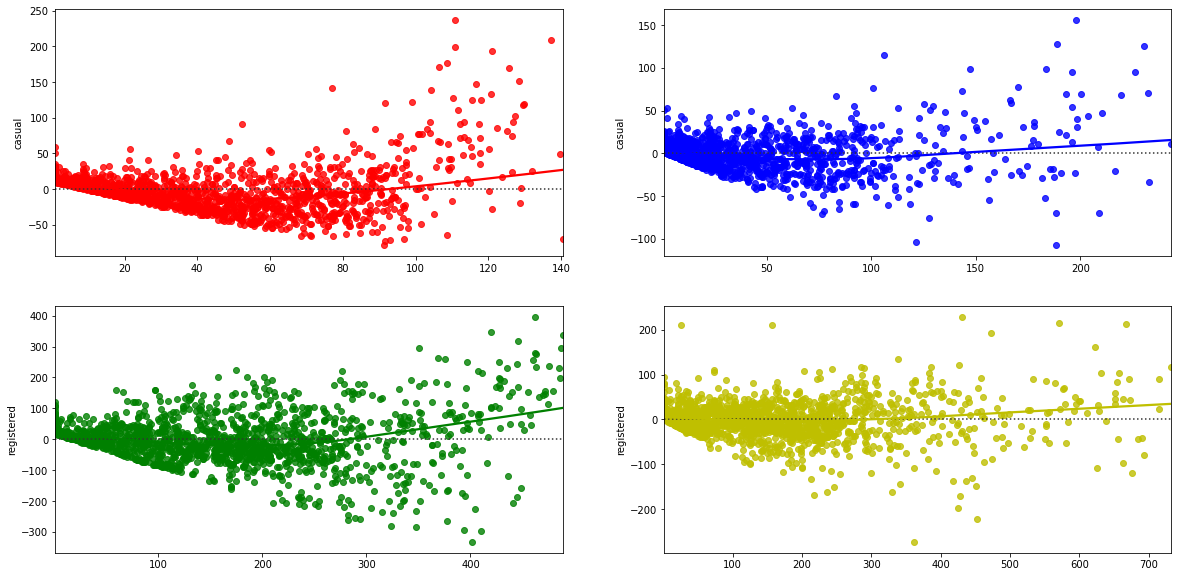

In [40]:
f,axes = plt.subplots(2,2,figsize = (20,10))
r1 = sb.residplot(x = pre_reg1, y = y1_test,lowess = True,color = 'r',ax = axes[0,0])
r2 = sb.residplot(x = pre_reg1_poly, y = y1_test,lowess = True,color = 'b',ax = axes[0,1])
r3 = sb.residplot(x = pre_reg2,y = y2_test,lowess = True,color = 'g',ax = axes[1,0])
r4 = sb.residplot(x = pre_reg2_poly, y = y2_test,lowess = True,color = 'y',ax = axes[1,1])

**Since the residual plots show a conical divergence therefore we can conclude that Linear Regression is definitely not a suitable model for the predicting in the above distribution of data**

Clearly the random forest model works best in this situation.

### Retraining the decision tree over the whole dataset for submission.

In [41]:
rf1 = RandomForestRegressor(max_depth = 50).fit(df_train_x,df_cas_train_y)
rf2 = RandomForestRegressor(max_depth = 60).fit(df_train_x,df_reg_train_y)

### Reading the test file

In [42]:
test_file = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

In [43]:
test=test_file
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


## Processing of the test file

In [44]:
test['mth'] = pd.DatetimeIndex(test['datetime']).month
test['yr'] = pd.DatetimeIndex(test['datetime']).year
test['dy'] = pd.DatetimeIndex(test['datetime']).day
test['hr'] = pd.DatetimeIndex(test['datetime']).hour

for i in test.groupby("season").count().index:
    s = 's' + str(i)
    a = []
    for j in test.season:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
for i in test.groupby("weather").count().index:
    s = 'w' + str(i)
    a = []
    for j in test.weather:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
for i in test.groupby('hr').count().index:
    s = 'hr'+str(i)
    a=[]
    for j in test.hr:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s]=a
for i in test.groupby("mth").count().index:
    s = 'm' + str(i)
    a = []
    for j in test.mth:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
test.sample(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,mth,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
3262,2012-01-21 15:00:00,1,0,0,3,8.20,9.850,80,12.9980,1,...,0,0,0,0,0,0,0,0,0,0
2414,2011-10-21 03:00:00,4,0,1,1,14.76,17.425,71,8.9981,10,...,0,0,0,0,0,0,0,1,0,0
5233,2012-08-23 21:00:00,3,0,1,1,28.70,32.575,61,8.9981,8,...,0,0,0,0,0,1,0,0,0,0
4165,2012-04-25 09:00:00,2,0,1,1,17.22,21.210,54,0.0000,4,...,0,1,0,0,0,0,0,0,0,0
729,2011-03-31 09:00:00,2,0,1,3,10.66,12.120,93,16.9979,3,...,1,0,0,0,0,0,0,0,0,0
2310,2011-09-27 19:00:00,4,0,1,2,26.24,28.790,89,8.9981,9,...,0,0,0,0,0,0,1,0,0,0
1225,2011-05-29 01:00:00,2,0,0,1,25.42,28.030,88,11.0014,5,...,0,0,1,0,0,0,0,0,0,0
3728,2012-02-29 03:00:00,1,0,1,1,11.48,15.150,70,6.0032,2,...,0,0,0,0,0,0,0,0,0,0
5066,2012-07-28 22:00:00,3,0,0,1,27.06,30.305,78,6.0032,7,...,0,0,0,0,1,0,0,0,0,0
4485,2012-05-27 17:00:00,2,0,0,1,31.98,35.605,49,19.9995,5,...,0,0,1,0,0,0,0,0,0,0


In [45]:
test = test[['hr0','hr1','hr2','hr3','hr4','hr5','hr6','hr7','hr8','hr9','hr10','hr11','hr12','hr13','hr14','hr15','hr16','hr17','hr18',
                 'hr19','hr20','hr21','hr22','hr23','m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12','yr',
                 's1','s2','s3','s4','holiday','workingday','w1','w2','w3','w4','temp','humidity']]
test.describe

<bound method NDFrame.describe of       hr0  hr1  hr2  hr3  hr4  hr5  hr6  hr7  hr8  hr9  ...  s3  s4  holiday  \
0       1    0    0    0    0    0    0    0    0    0  ...   0   0        0   
1       0    1    0    0    0    0    0    0    0    0  ...   0   0        0   
2       0    0    1    0    0    0    0    0    0    0  ...   0   0        0   
3       0    0    0    1    0    0    0    0    0    0  ...   0   0        0   
4       0    0    0    0    1    0    0    0    0    0  ...   0   0        0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..      ...   
6488    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6489    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6490    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6491    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6492    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   

     

## Predicting the output over test set

In [46]:
pre_cas = rf1.predict(test)
pre_reg = rf2.predict(test)
final_predictions = pd.DataFrame(pre_cas+pre_reg,columns = ['cout'])

final_predictions.describe

<bound method NDFrame.describe of             cout
0      12.088000
1       4.540000
2       3.550000
3       3.020000
4       2.220000
...          ...
6488  229.970000
6489  152.660000
6490  125.170000
6491   99.450000
6492   62.517667

[6493 rows x 1 columns]>

In [47]:
s=[]
for j in final_predictions.cout:
    if int(j)<1:
        s.append(1)
    else:
        s.append(j)
final_predictions['count'] = s 

**Since we know that the output is never less than 1 we have to replace all negative values with 1.**

In [48]:
final_predictions.describe

<bound method NDFrame.describe of             cout       count
0      12.088000   12.088000
1       4.540000    4.540000
2       3.550000    3.550000
3       3.020000    3.020000
4       2.220000    2.220000
...          ...         ...
6488  229.970000  229.970000
6489  152.660000  152.660000
6490  125.170000  125.170000
6491   99.450000   99.450000
6492   62.517667   62.517667

[6493 rows x 2 columns]>

In [49]:
final_predictions['datetime']=test_file['datetime']
final_predictions = final_predictions[['datetime','count']]

In [50]:
final_predictions.describe()

,count
count,6493.00000
mean,191.04072
std,171.37334
min,1.56500
25%,52.65000
50%,149.55000
75%,281.03500
max,916.35000


## Exporting output to csv

In [51]:
final_predictions.to_csv('submission.csv',index=False)